In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import random

ModuleNotFoundError: No module named 'tqdm'

In [2]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def posterior_array(log_freq_percept, n_tones, p_back, p_low, 
                    log_prior_low, log_prior_high):
    """
    Arguments: 
    log_freq_percept - range of all possible frequencies (percepts?)
    p_back - prob of background, p_low - prob of low condition
    log_prior_low - gaussian of low condition
    log_prior_high - gaussian of high condition
    """
    
    log_prior_low_mean = log_prior_low[0]; log_prior_low_sigma = log_prior_low[1];
    log_prior_high_mean = log_prior_high[0]; log_prior_high_sigma = log_prior_high[1];
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
    
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif n_tones == 2:
        prior_tones_low = prior_dist_mixed_low@np.transpose(prior_dist_mixed_low)
        prior_tones_high = prior_dist_mixed_high@np.transpose(prior_dist_mixed_high)
        
    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, posterior

In [34]:
# experimental task
def task(freq_seq, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*20)
    log_freq_seq_mid = np.median(log_freq_seq_array)
    log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian 
    log_freq_high = [log_freq_seq_mid + 0.2,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                if np.random.random() < 0.5:                    
                    nearest_log_tone = \
                    np.random.choice(log_freq_seq_array[0:np.argmin(np.abs(log_freq_seq_array -\
                                                        (log_freq_low[0]-0*log_freq_low[1])))])
                else:
                    nearest_log_tone = \
                    np.random.choice(log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array -\
                                                        (log_freq_high[0]+0*log_freq_high[1]))):-1])
                #background freq is chosen from a uniform distribution
                tone_kind.append('b')
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])                    
                    tone_kind.append('l')
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])
                    tone_kind.append('h')
                nearest_log_tone = log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high

In [35]:
# Given only one true tone
"""
Sample experiment
"""
expt_tones = np.arange(100,2000,1) #array of possible true tones
trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high \
= task(freq_seq = expt_tones, n_trials = 150, n_tones = 1)


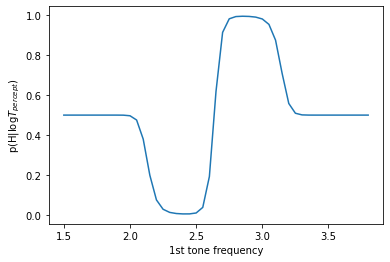

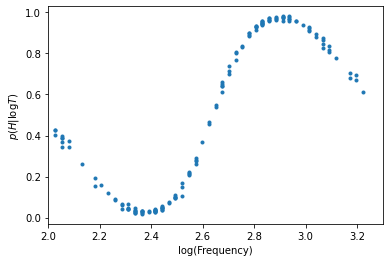

In [44]:
"""
One tone
Perceptual tones have a longer range than the experimental tones.
"""

log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, np.log10(expt_tones[-1])+0.5, 0.05) 

prior_dist_mixed_high, prior_dist_mixed_low, posterior = \
posterior_array(log_freq_percept, n_tones=1, p_back=0.2, p_low=0.5, \
               log_prior_low=log_freq_low, log_prior_high=log_freq_high)
            
plt.plot(log_freq_percept,posterior)
plt.xlabel('1st tone frequency')
plt.ylabel('p(H|$\log T_{percept}$)')
plt.show()      
        
"""
Trying two routes - 1. what if we have both sensory noise in that the perceived tones are from a gaussian 
whose mean is the true tone and we have decision noise in that the at a particular perceived tone the observer chooses
high with probability p(H|T). So a trial is basically defined as [trial_tone, perceived_tone and decision]
2. what if we only have sensory noise and the decision made is the best decision at a particular perceived tone. 

"""    
all_trial_tones = np.empty((len(trial_tones)*1000,1))
all_trial_behaviour = np.empty((len(trial_tones)*1000,1))
prob_trial_behaviour = np.empty((len(trial_tones),1))
i_trial = 0
for i_stim in range(len(trial_tones)):
    i_trial += 1
    input_array = np.random.normal(loc=np.log10(trial_tones[i_stim]),scale=0.1,size=1000) \
    #pick tones from the gaussian with mean as log(true_tone) and sigma 0.1
    perc_tone_idxs = np.argmin(np.abs(np.transpose(np.tile(np.expand_dims(log_freq_percept,1),(1,1000))) \
                                       - np.expand_dims(input_array,axis=1)),axis=1)  
    # find relevant adjacent freq percepts
    perc_tone_array = log_freq_percept[perc_tone_idxs]
    posterior_perc_tone = posterior[perc_tone_idxs]
    trial_behaviour = (np.random.random_sample(size=1000) < np.squeeze(posterior_perc_tone)).astype(int)
    # this encodes decision noise
    # trial_behaviour = np.squeeze(posterior_perc_tone) > 0.5
    # this makes the same choice for one tone percept every time that tone is perceived
    all_trial_tones[(i_trial-1)*1000:i_trial*1000] = trial_tones[i_stim]
    all_trial_behaviour[(i_trial-1)*1000:i_trial*1000] = np.expand_dims(trial_behaviour, axis=1)
    prob_trial_behaviour[i_stim] = np.mean(trial_behaviour)
    
plt.plot(np.log10(trial_tones),prob_trial_behaviour,'.')    
plt.xlim(np.log10(expt_tones[0]),np.log10(expt_tones[-1]))
plt.ylabel('$p(H|\log T)$')
plt.xlabel('log(Frequency)')

"""
Shuffling the tones and the behaviour to simluate an experiment
"""
s = np.arange(all_trial_tones.shape[0])
np.random.shuffle(s)
all_trial_tones = all_trial_tones[s]
all_trial_behaviour = all_trial_behaviour[s]

In [ ]:
# define mle function
def MLE(params):
    log_prior_low_mean, log_prior_low_sigma, log_prior_high_mean, log_prior_high_sigma, p_back = \
    params[0], params[1], params[2], params[3], params[4] # inputs are guesses at our parameters
    
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high #mixture model
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low #mixture model
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)

    if len(trial_tones[0]) == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
        
    elif len(trial_tones[0]) == 2:
        prior_tones_low = prior_dist_mixed_low@np.transpose(prior_dist_mixed_low)
        #p(T1,T2..|L) 
        prior_tones_high = prior_dist_mixed_high@np.transpose(prior_dist_mixed_high)
        #p(T1,T2..|H) 
        
    elif len(trial_tones[0]) == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
    
    p_low = 0.5 
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer  
        
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        if len(trial_tones[i_trial]) == 1:
            input_array = np.random.normal(loc=np.log10(trial_tones[i_trial]),scale=0.1,size=1000) \
            #pick tones from the gaussian with mean as log(true_tone) and sigma 0.1
            perc_tone_idxs = np.argmin(np.abs(np.transpose(np.tile(np.expand_dims(log_freq_percept,1),(1,1000))) \
                                               - np.expand_dims(input_array,axis=1)),axis=1)  
            # find relevant adjacent freq percepts
            perc_tone_array = log_freq_percept[perc_tone_idxs]
            posterior_perc_tone = posterior[perc_tone_idxs]
            trial_behaviour = (np.random.random_sample(size=1000) < np.squeeze(posterior_perc_tone)).astype(int)
            # this encodes decision noise
            # trial_behaviour = np.squeeze(posterior_perc_tone) > 0.5
            # this makes the same choice for one tone percept every time that tone is perceived
            all_trial_tones[(i_trial-1)*1000:i_trial*1000] = trial_tones[i_stim]
            all_trial_behaviour[(i_trial-1)*1000:i_trial*1000] = np.expand_dims(trial_behaviour, axis=1)
            prob_trial_behaviour[i_stim] = np.mean(trial_behaviour)      
            
        if trial_behaviour[i_trial]:
            neg_ll += -np.log(probability_high0 + np.finfo(float).eps) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + np.finfo(float).eps) # if low dist is chosen by observer
        if np.isnan(np.log(probability_high0 + 0.00001)) \
        or np.isinf(np.log(probability_high0 + 0.00001)) \
        or np.isnan(np.log(1 - probability_high0 + 0.00001)) \
        or np.isinf(np.log(1 - probability_high0 + 0.00001)):
            pdb.set_trace()        
    return(neg_ll)